In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

2024-03-07 10:53:24.790489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Read data

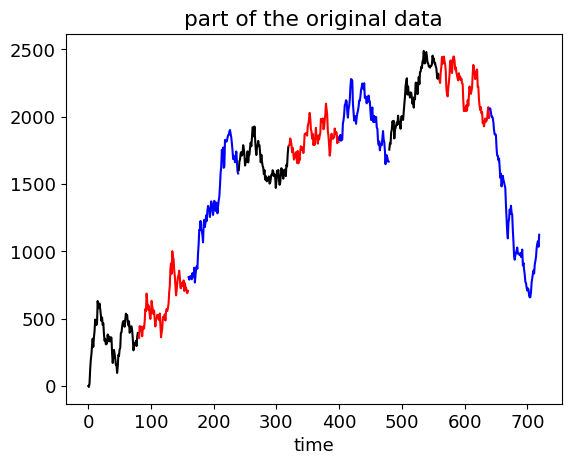

data:  4000


In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

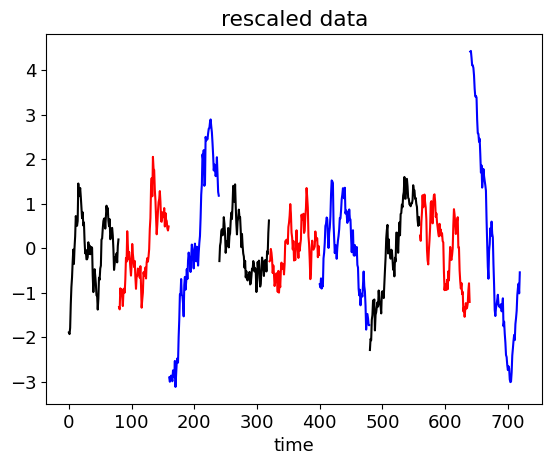

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [4]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV=2

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .Adam()
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.RMSprop()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

print(model.layers)

----- Model 2 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 5)             60        
                                                                 
 conv1d_1 (Conv1D)           (None, 67, 5)             105       
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 5)             105       
                                                                 
 global_max_pooling1d (Glob  (None, 5)                 0         
 alMaxPooling1D)                                                 
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                    

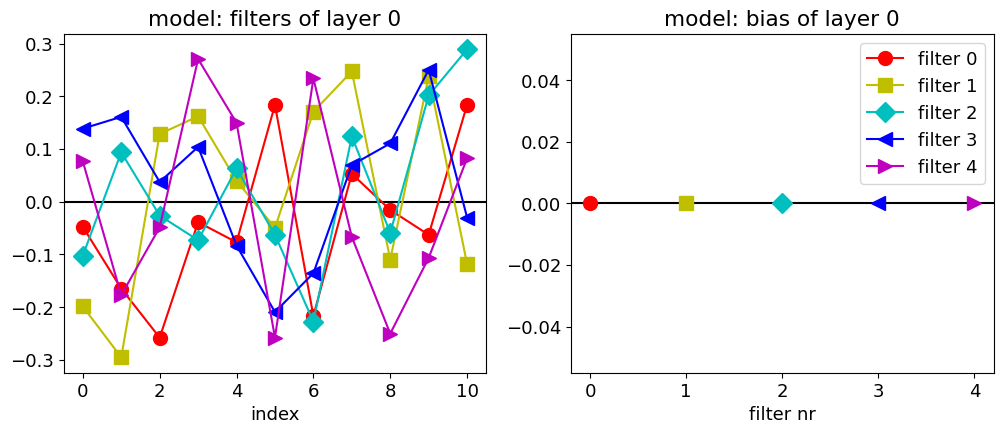

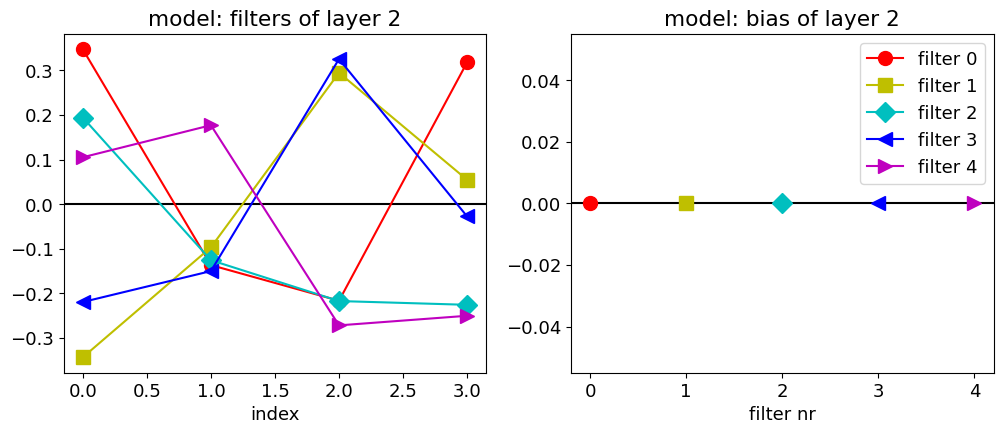

In [5]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [6]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 
print("end of fit")

----- Model  2 -----
FITTING....
Epoch 1/300
16/16 - 1s - loss: 1.1032 - accuracy: 0.3322 - val_loss: 1.0955 - val_accuracy: 0.3338 - 1s/epoch - 76ms/step
Epoch 2/300
16/16 - 0s - loss: 1.0915 - accuracy: 0.3347 - val_loss: 1.0886 - val_accuracy: 0.3400 - 120ms/epoch - 8ms/step
Epoch 3/300
16/16 - 0s - loss: 1.0840 - accuracy: 0.3503 - val_loss: 1.0826 - val_accuracy: 0.3475 - 119ms/epoch - 7ms/step
Epoch 4/300
16/16 - 0s - loss: 1.0764 - accuracy: 0.3722 - val_loss: 1.0753 - val_accuracy: 0.3638 - 118ms/epoch - 7ms/step
Epoch 5/300
16/16 - 0s - loss: 1.0677 - accuracy: 0.4078 - val_loss: 1.0652 - val_accuracy: 0.3975 - 119ms/epoch - 7ms/step
Epoch 6/300
16/16 - 0s - loss: 1.0571 - accuracy: 0.4450 - val_loss: 1.0538 - val_accuracy: 0.4375 - 121ms/epoch - 8ms/step
Epoch 7/300
16/16 - 0s - loss: 1.0447 - accuracy: 0.4809 - val_loss: 1.0401 - val_accuracy: 0.4675 - 118ms/epoch - 7ms/step
Epoch 8/300
16/16 - 0s - loss: 1.0306 - accuracy: 0.5034 - val_loss: 1.0254 - val_accuracy: 0.5000 - 

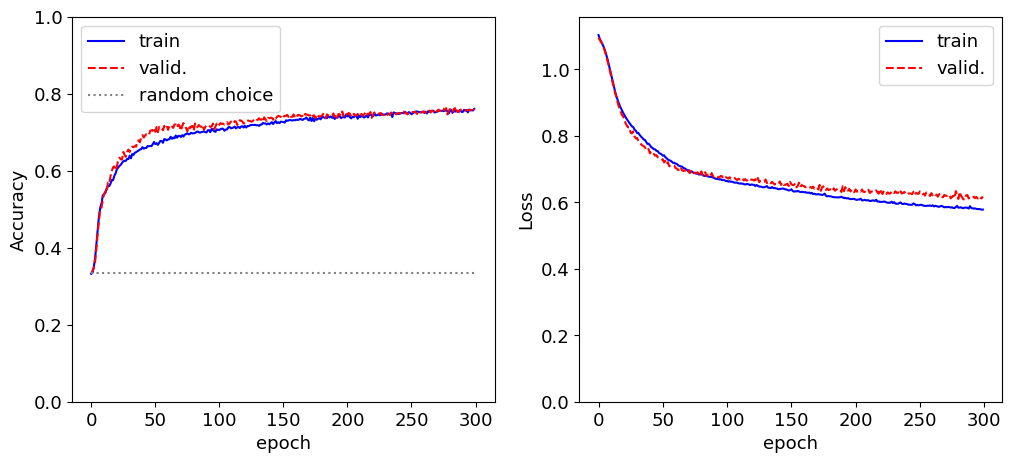

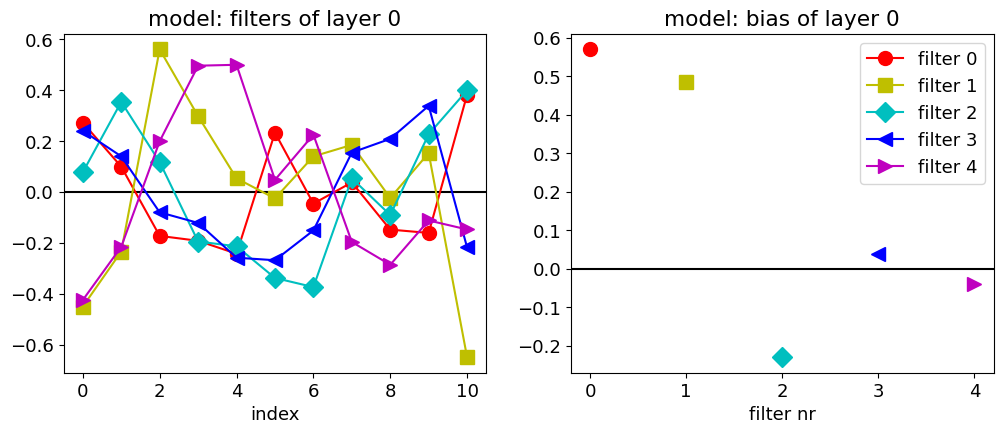

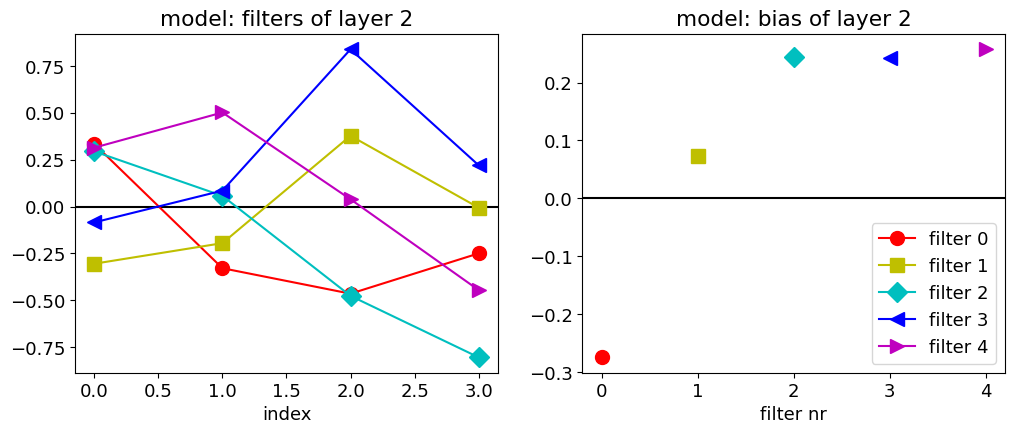

In [7]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

25/25 [==============================] - 0s 1ms/step


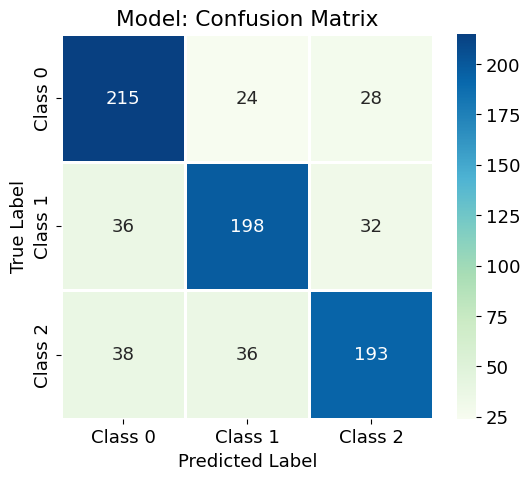

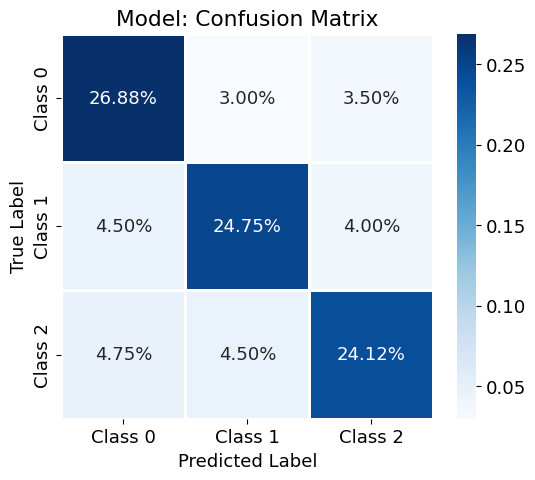

In [8]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

In [9]:
model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.legacy.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

Epoch 1/300
16/16 - 1s - loss: 1.3005 - accuracy: 0.3328 - val_loss: 1.1916 - val_accuracy: 0.3313 - 754ms/epoch - 47ms/step
Epoch 2/300
16/16 - 0s - loss: 1.1559 - accuracy: 0.3103 - val_loss: 1.1247 - val_accuracy: 0.3025 - 117ms/epoch - 7ms/step
Epoch 3/300
16/16 - 0s - loss: 1.1149 - accuracy: 0.3266 - val_loss: 1.1076 - val_accuracy: 0.3288 - 129ms/epoch - 8ms/step
Epoch 4/300
16/16 - 0s - loss: 1.1048 - accuracy: 0.3391 - val_loss: 1.1018 - val_accuracy: 0.3350 - 134ms/epoch - 8ms/step
Epoch 5/300
16/16 - 0s - loss: 1.1001 - accuracy: 0.3431 - val_loss: 1.0986 - val_accuracy: 0.3500 - 136ms/epoch - 8ms/step
Epoch 6/300
16/16 - 0s - loss: 1.0973 - accuracy: 0.3500 - val_loss: 1.0957 - val_accuracy: 0.3500 - 133ms/epoch - 8ms/step
Epoch 7/300
16/16 - 0s - loss: 1.0945 - accuracy: 0.3547 - val_loss: 1.0923 - val_accuracy: 0.3562 - 134ms/epoch - 8ms/step
Epoch 8/300
16/16 - 0s - loss: 1.0907 - accuracy: 0.3641 - val_loss: 1.0879 - val_accuracy: 0.3537 - 144ms/epoch - 9ms/step
Epoch 9

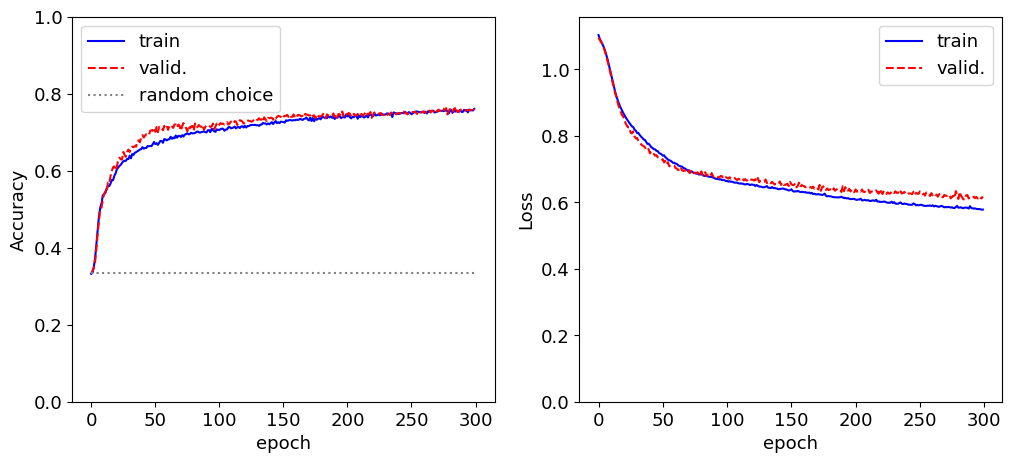

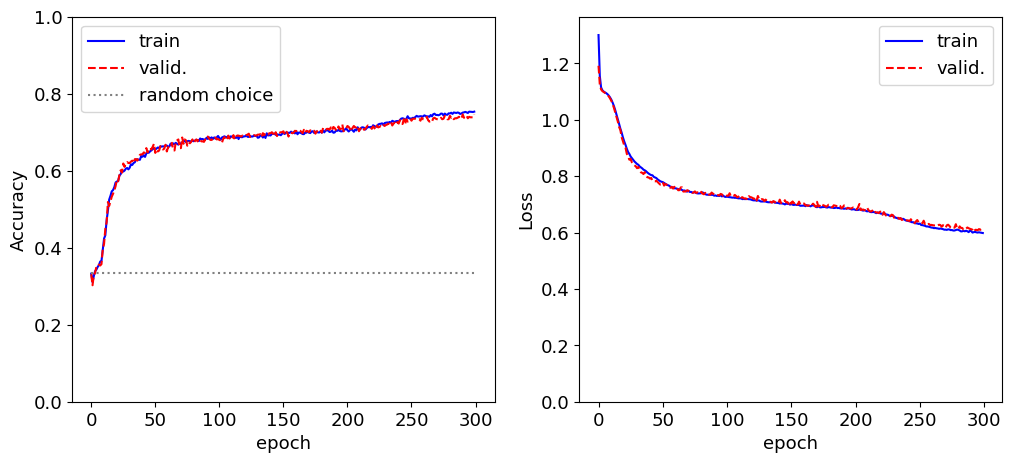

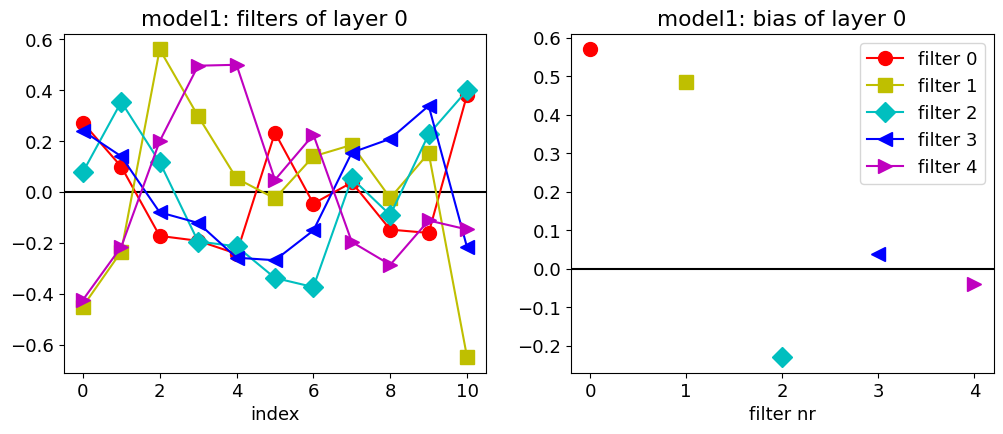

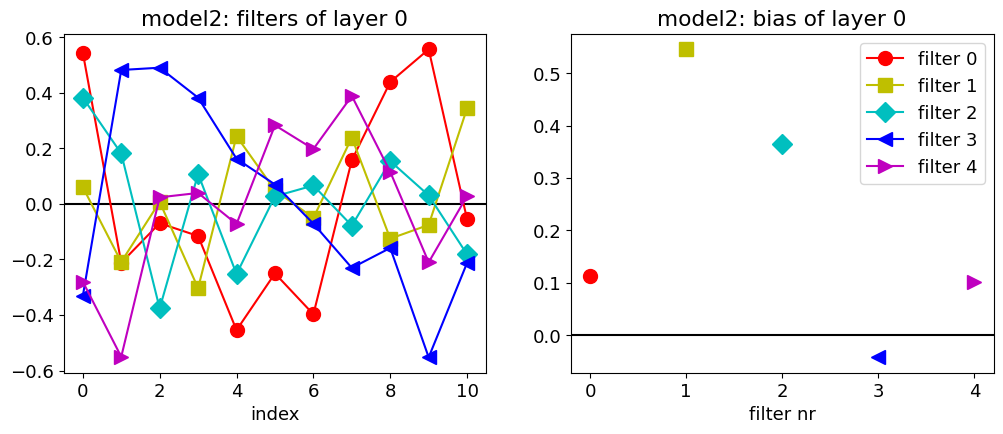

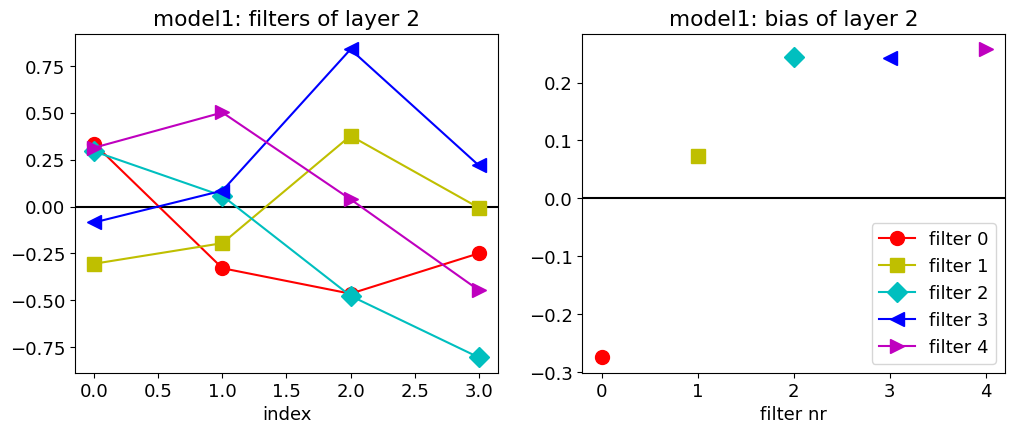

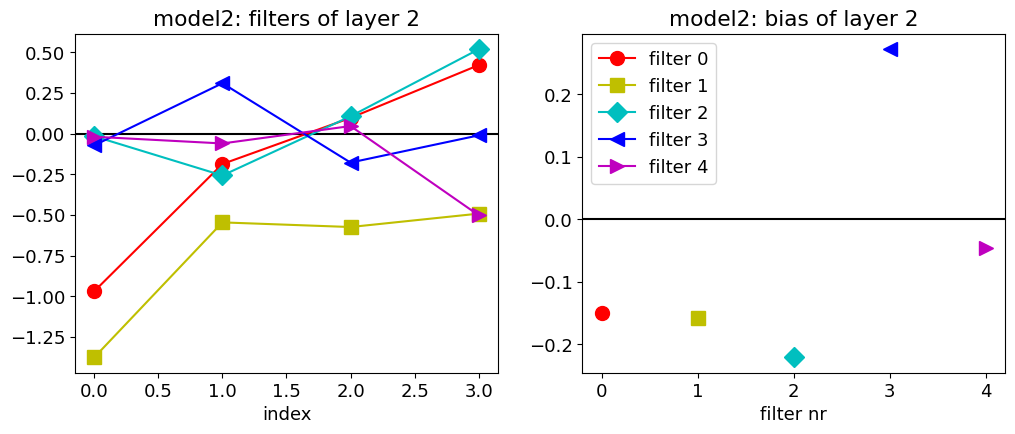

25/25 [==============================] - 0s 2ms/step


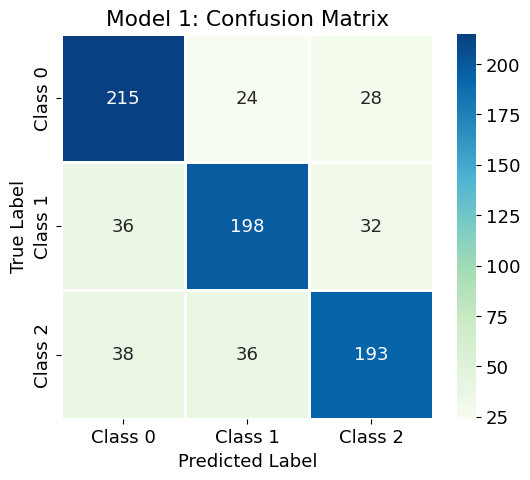

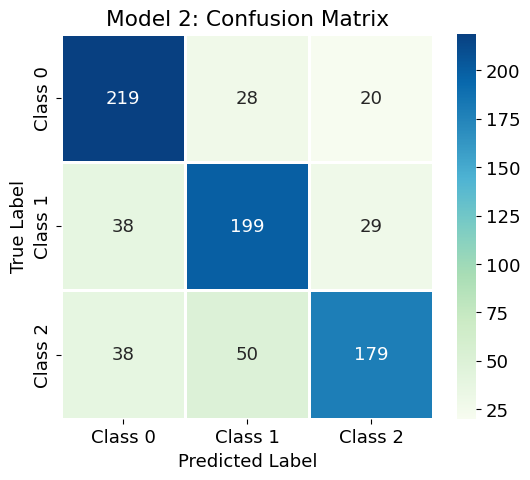

In [10]:

Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")


y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

# Solution 1.

As regard to the first point of the exercises, on the basis of the obtained results we chose the CNN version ending with a global max pooling layer (G). It can indeed be observed, from the available plots of training and validation errors through the $300$ epochs, that overfitting appears to occur with and without regularization. For the G version, instead, the training and validation accuracies are very similar, and the regularization term introduces smoothing of the relative curves.

# Solution 2.

In [11]:
def plot_models(opts):
    
    N_fits = 5
    
    for o in opts:
        for _ in range(N_fits):
            
            model=build_model(NCONV=2,KS=11)
            model.compile(loss=keras.losses.categorical_crossentropy, optimizer = o, metrics = ['accuracy'])
    
            BATCH_SIZE = 200
            EPOCHS = 50
    
            fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=1, shuffle=True)
    
            Show_history(fit)

OPTIMIZER: ADAM
Learning rate: 0.00001 (Run: 1)
Learning rate: 0.00001 (Run: 2)
Learning rate: 0.00001 (Run: 3)
Learning rate: 0.00001 (Run: 4)
Learning rate: 0.00001 (Run: 5)
Learning rate: 0.00003 (Run: 1)
Learning rate: 0.00003 (Run: 2)
Learning rate: 0.00003 (Run: 3)
Learning rate: 0.00003 (Run: 4)
Learning rate: 0.00003 (Run: 5)
Learning rate: 0.00010 (Run: 1)
Learning rate: 0.00010 (Run: 2)
Learning rate: 0.00010 (Run: 3)
Learning rate: 0.00010 (Run: 4)
Learning rate: 0.00010 (Run: 5)
Learning rate: 0.00032 (Run: 1)
Learning rate: 0.00032 (Run: 2)
Learning rate: 0.00032 (Run: 3)
Learning rate: 0.00032 (Run: 4)
Learning rate: 0.00032 (Run: 5)
Learning rate: 0.00100 (Run: 1)
Learning rate: 0.00100 (Run: 2)
Learning rate: 0.00100 (Run: 3)
Learning rate: 0.00100 (Run: 4)
Learning rate: 0.00100 (Run: 5)
OPTIMIZER: RMS
Learning rate: 0.00001 (Run: 1)
Learning rate: 0.00001 (Run: 2)
Learning rate: 0.00001 (Run: 3)
Learning rate: 0.00001 (Run: 4)
Learning rate: 0.00001 (Run: 5)
Learning 

Learning rate: 0.00100 (Run: 5)
OPTIMIZER: SGD


Learning rate: 0.00001 (Run: 1)


Learning rate: 0.00001 (Run: 2)


Learning rate: 0.00001 (Run: 3)


Learning rate: 0.00001 (Run: 4)


Learning rate: 0.00001 (Run: 5)


Learning rate: 0.00003 (Run: 1)


Learning rate: 0.00003 (Run: 2)


Learning rate: 0.00003 (Run: 3)


Learning rate: 0.00003 (Run: 4)


Learning rate: 0.00003 (Run: 5)


Learning rate: 0.00010 (Run: 1)


Learning rate: 0.00010 (Run: 2)


Learning rate: 0.00010 (Run: 3)


Learning rate: 0.00010 (Run: 4)


Learning rate: 0.00010 (Run: 5)


Learning rate: 0.00032 (Run: 1)


Learning rate: 0.00032 (Run: 2)


Learning rate: 0.00032 (Run: 3)


Learning rate: 0.00032 (Run: 4)


Learning rate: 0.00032 (Run: 5)


Learning rate: 0.00100 (Run: 1)


Learning rate: 0.00100 (Run: 2)


Learning rate: 0.00100 (Run: 3)


Learning rate: 0.00100 (Run: 4)
Learning rate: 0.00100 (Run: 5)


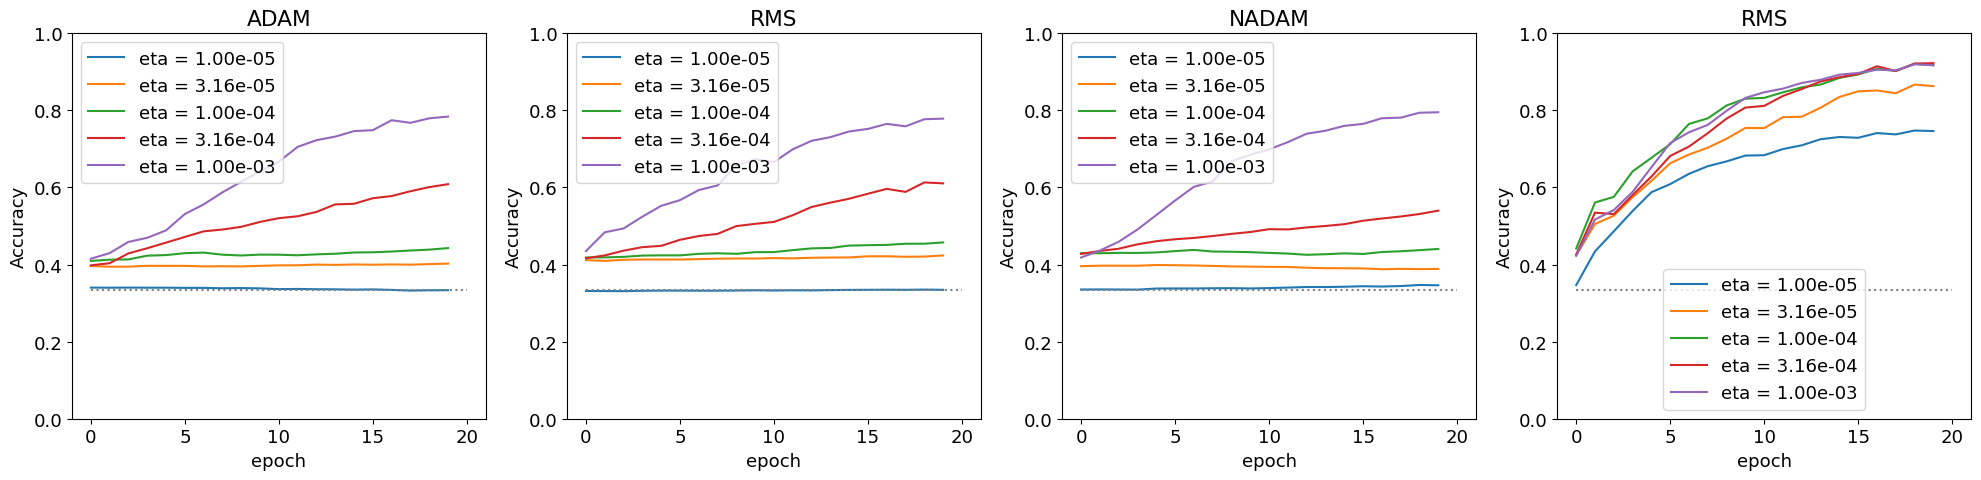

In [36]:
# eta = [np.logspace(-5, -3, 5)]
# opts = [keras.optimizers.Adam(learning_rate = e) for e in eta]

# plot_models(opts)

BATCH_SIZE = 100
EPOCHS = 20

# Show_history(fit)

N_run = 5
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


#0--------------------------------------------------------------#
ax00 = fig.add_subplot(1, 4, 1)
val_tot = np.zeros(EPOCHS)

etas_adam = np.logspace(-5, -3, 5)

print("OPTIMIZER: ADAM")

for e in etas_adam:
    for i in range(N_run):
        model_i = keras.models.clone_model(model)
        opt = keras.optimizers.Adam(learning_rate = e)
        model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
        fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
        val_tot += np.array(fit.history['val_accuracy'])
        print(f"Learning rate: {e:.5f} (Run: {i+1})")

    val_tot = [v / N_run for v in val_tot]

    ax00.plot(val_tot,label=f"eta = {e:.2e}")
    
ax00.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
ax00.set_title('ADAM')
ax00.set_xlabel('epoch')
ax00.set_ylabel("Accuracy")
ax00.set_ylim([0, 1])
ax00.legend()

#1--------------------------------------------------------------#
ax01 = fig.add_subplot(1, 4, 2)
val_tot = np.zeros(EPOCHS)

etas_adam = np.logspace(-5, -3, 5)

print("OPTIMIZER: RMS")

for e in etas_adam:
    for i in range(N_run):
        model_i = keras.models.clone_model(model)
        opt = keras.optimizers.RMSprop(learning_rate = e)
        model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
        fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
        val_tot += np.array(fit.history['val_accuracy'])
        print(f"Learning rate: {e:.5f} (Run: {i+1})")

    val_tot = [v / N_run for v in val_tot]

    ax01.plot(val_tot,label=f"eta = {e:.2e}")
    
ax01.set_title('RMS')
ax01.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
ax01.set_xlabel('epoch')
ax01.set_ylabel("Accuracy")
ax01.set_ylim([0, 1])
ax01.legend()

#2--------------------------------------------------------------#
ax02 = fig.add_subplot(1, 4, 3)
val_tot = np.zeros(EPOCHS)

etas_adam = np.logspace(-5, -3, 5)

print("OPTIMIZER: NADAM")

for e in etas_adam:
    for i in range(N_run):
        model_i = keras.models.clone_model(model)
        opt = keras.optimizers.Nadam(learning_rate = e)
        model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
        fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
        val_tot += np.array(fit.history['val_accuracy'])
        print(f"Learning rate: {e:.5f} (Run: {i+1})")

    val_tot = [v / N_run for v in val_tot]

    ax02.plot(val_tot,label=f"eta = {e:.2e}")
    
ax02.set_title('NADAM')
ax02.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
ax02.set_xlabel('epoch')
ax02.set_ylabel("Accuracy")
ax02.set_ylim([0, 1])
ax02.legend()

#3--------------------------------------------------------------#
ax03 = fig.add_subplot(1, 4, 4)
val_tot = np.zeros(EPOCHS)

etas_adam = np.logspace(-5, -3, 5)

print("OPTIMIZER: SGD")

for e in etas_adam:
    for i in range(N_run):
        model_i = keras.models.clone_model(model)
        opt = keras.optimizers.SGD(learning_rate = e, momentum = 0.9, nesterov = True)
        model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
        fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
        val_tot += np.array(fit.history['val_accuracy'])
        print(f"Learning rate: {e:.5f} (Run: {i+1})")

    val_tot = [v / N_run for v in val_tot]

    ax03.plot(val_tot,label=f"eta = {e:.2e}")
    
ax03.set_title('SGD')
ax03.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
ax03.set_xlabel('epoch')
ax03.set_ylabel("Accuracy")
ax03.set_ylim([0, 1])
ax03.legend()


plt.tight_layout()
plt.show()